##Import various python functions and modules that we need.

In [1]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

##Import R libraries we'll use.

In [3]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)

foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Loading required package: grid


##Import data into R. Prune to relevant samples (PS, non-bulk). Get rid of OTUs not observed in at least 25% of samples)

###These files are from the [binning notebook](./OTU_binning.ipynb), [tree notebook](./Tree.ipynb), [merge mappers notebook](./Merge_mappers.ipynb) 

In [4]:
%%R
physeq = import_biom("/var/seq_data/priming_exp/data/otu_table.biom", "/var/seq_data/priming_exp/data/otusn.tree")
#print(physeq)
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
#print(sample.data)
physeq = merge_phyloseq(physeq,sample.data)
#print(physeq)
physeq.md = sample_data(physeq)
physeq.PE = prune_samples((physeq.md$Bulk == 0)&
                          (!(physeq.md$Sample %in% c("13C.700.45.03.21", "12C.000.28.03.27")))&
                          (physeq.md$Treatment %in% c("12C000","13C000")), physeq)
physeq.PE.snorm = transform_sample_counts(physeq.PE, function(x) x/sum(x))
physeq.PE.thresh = filter_taxa(physeq.PE.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.PE.thresh)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3279 taxa and 127 samples ]
sample_data() Sample Data:       [ 127 samples by 13 sample variables ]
phy_tree()    Phylogenetic Tree: [ 3279 tips and 3278 internal nodes ]


In [5]:
%%R
print(colnames(physeq.md))

 [1] "Sample"       "FractionNum"  "Bulk"         "Control"      "CC"          
 [6] "X100"         "X700"         "H2O"          "Day"          "Density"     
[11] "rep"          "contolVlabel" "Treatment"   


###Calculate pairwise weighted unifrac distances between samples.

In [6]:
%%R
registerDoParallel(cores=20)
wunif.dist = distance(physeq.PE.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

###Ordinate using weighted unifrac distnaces with NMDS.

In [7]:
%%R
nmds = ordinate(physeq.PE.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

Run 0 stress 0.0764548 
Run 1 stress 0.08230804 
Run 2 stress 0.08140165 
Run 3 stress 0.09008956 
Run 4 stress 0.08109421 
Run 5 stress 0.08109264 
Run 6 stress 0.08109342 
Run 7 stress 0.07616362 
... New best solution
... procrustes: rmse 0.006060579  max resid 0.06699562 
Run 8 stress 0.08109315 
Run 9 stress 0.08261398 
Run 10 stress 0.0785995 
Run 11 stress 0.08140154 
Run 12 stress 0.08140154 
Run 13 stress 0.07616363 
... procrustes: rmse 0.0001800755  max resid 0.00142056 
*** Solution reached


NULL


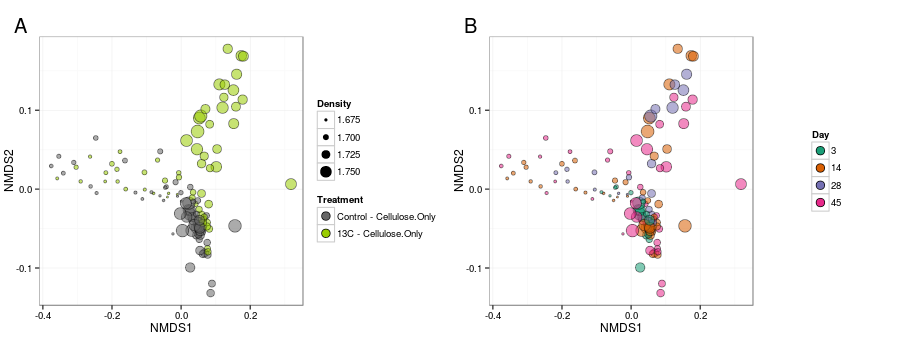

In [8]:
%%R -w 900 -h 350

colours = c("#666666", "#99CC00", "#ff7f00", "#377eb8", "#4daf4a", "#00f5ff", "#ff4040", "#68228b")

df = plot_ordination(physeq.PE.thresh, nmds, justDF = TRUE)
df$Density = as.numeric(as.character(df$Density))

p1 = ggplot(df, aes(x = NMDS1, y = NMDS2)) 
p1 = p1 + geom_point(aes(fill = Treatment, size = Density, alpha = 0.85), shape=21) 
p1 = p1 + scale_fill_manual(values = colours,
                            breaks=c("12C000", "13C000"),
                            labels=c("Control - Cellulose.Only", "13C - Cellulose.Only"))
p1 = p1 + guides(alpha = FALSE)
p1 = p1 + scale_size_area(aesthetics = "Density")
p1 = p1 + ggtitle("A")
p1 = p1 + guides(fill = guide_legend(override.aes = list(size = 4)))
p1 = p1 + guides(size = guide_legend(override.aes = list(fill = "black")))
p1 = p1 + theme_bw()
p1 = p1 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p2 = ggplot(df, aes(x = NMDS1, y = NMDS2))
p2 = p2 + geom_point(aes(fill = factor(Day), size = Density, alpha = 0.85), shape=21)
p2 = p2 + scale_fill_brewer(palette="Dark2")
p2 = p2 + guides(alpha = FALSE, size = FALSE)
p2 = p2 + scale_size_area(aesthetics = "Density")
p2 = p2 + ggtitle("B")
p2 = p2 + guides(fill = guide_legend(title = "Day", override.aes = list(size = 4)))
p2 = p2 + theme_bw()
p2 = p2 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p2 = p2 + theme(plot.title = element_text(hjust = -0.1, size = 20))


gp1 = ggplot_gtable(ggplot_build(p1))
gp2 = ggplot_gtable(ggplot_build(p2))
maxWidth = unit.pmax(gp1$widths[2:5], gp2$widths[2:5])

gp1$widths[2:5] <- maxWidth
gp2$widths[2:5] <- maxWidth

p.combined = grid.arrange(gp1, gp2, ncol = 2)
p.combined

In [9]:
%%R -w 1000 -h 350
pdf("figs/ordination_CC.pdf", width = 12, height = 5)
grid.arrange(p1, p2, widths = c(1.3, 1), ncol=2)
dev.off()

png 
  2 


In [10]:
FileLink("figs/ordination_CC.pdf")

/home/ashley/priming_exp/figs/ordination_CC.pdf

In [11]:
%%R 
png("figs/ordination_CC.png", width = 12, height = 5, units = "in", res = 600)
grid.arrange(p1, p2, widths = c(1.2, 1), ncol=2)
dev.off()

png 
  2 


In [12]:
FileLink("figs/ordination_CC.png")

/home/ashley/priming_exp/figs/ordination_CC.png